# Scientific Programming Project - Liam Glueck
# Predicting tumour type from MRI image arrays

We're going to be using MRI scans to classify the tumour type based on the image arrays
Overall the script will include: 
- General data loading and exploration
- cleaning the data
- Transforming the data
- PCA 
- Upsampling
- Model training using: 
    - K-Nearest Neighbours
    - Support Vector Machines
    

Installing the necessary packages and functions

In [ ]:
import os
import statistics
import numpy as np
from PIL import Image
from mat73 import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statistics import mode 
import PIL 
import glob

Setting our directory, you just need to replace the file location exactly as you see it with your directory

In [23]:
cd /Users/liamg/Documents/Uni/Scientific Programming/Project/BTDS

/Users/liamg/Documents/Uni/Scientific Programming/Project/BTDS


Can quickly check the files in our directory to make sure all 3064 images are present. 

In [24]:
ls 

1.mat                192.mat              2840.mat
10.mat               1920.mat             2841.mat
100.mat              1921.mat             2842.mat
1000.mat             1922.mat             2843.mat
1001.mat             1923.mat             2844.mat
1002.mat             1924.mat             2845.mat
1003.mat             1925.mat             2846.mat
1004.mat             1926.mat             2847.mat
1005.mat             1927.mat             2848.mat
1006.mat             1928.mat             2849.mat
1007.mat             1929.mat             285.mat
1008.mat             193.mat              2850.mat
1009.mat             1930.mat             2851.mat
101.mat              1931.mat             2852.mat
1010.mat             1932.mat             2853.mat
1011.mat             1933.mat             2854.mat
1012.mat             1934.mat             2855.mat
1013.mat             1935.mat             2856.mat
1014.mat             1936.mat             2857.mat
1015.mat             1937.mat   

Say we want to iterate through the first 100 images to plot them just to take a look.
We're just doing the first hundred as, plotting all 3000 of the images simply takes a lot of time and memory for how much time we'll actually spend looking at the images themselves. 

One of the initial observations from the plots below that I want to make clear, is that no two images from the same patient are the same. 

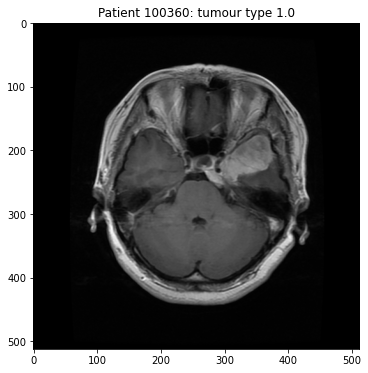

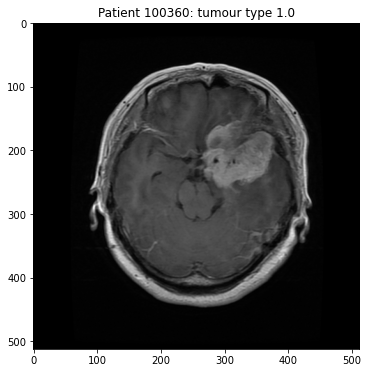

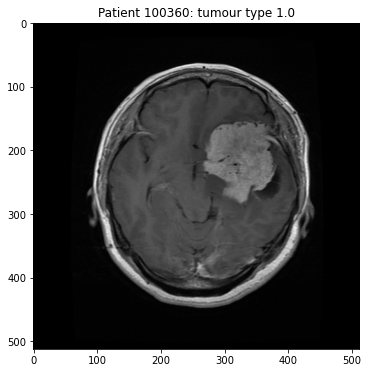

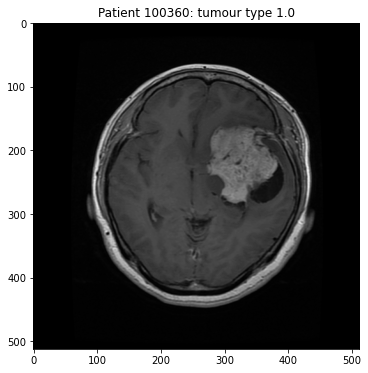

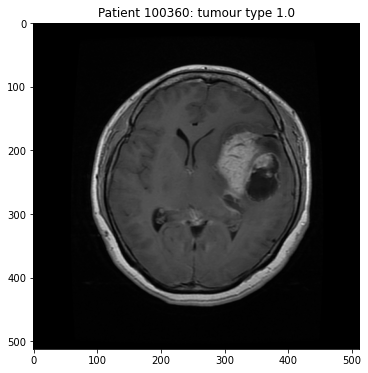

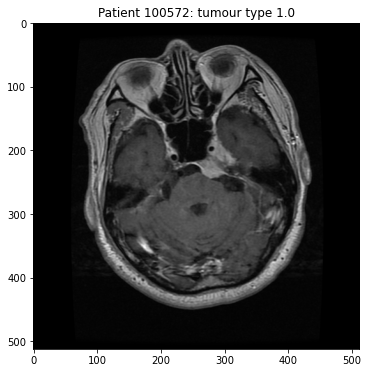

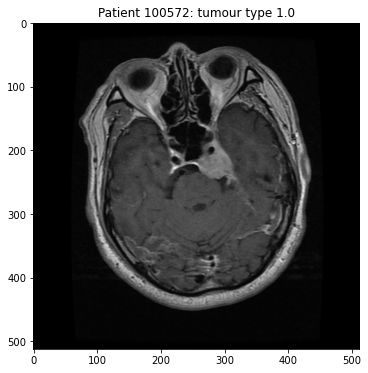

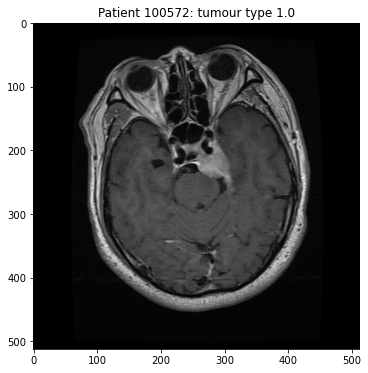

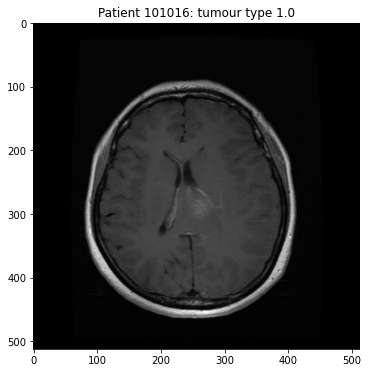

In [339]:
idx = range(1, 10)
for i in idx:
    path = f'/Users/liamg/Documents/Uni/Scientific Programming/Project/BTDS/{i}.mat'
    data = loadmat(path)
    data
    img = data['cjdata']
    plt.figure(figsize=(10,6))
    plt.gray()
    j = img['PID']
    im = img['image']
    lab = img['label']
    plt.title(f'Patient {j}: tumour type {lab}')
    plt.imshow(im)

When printing the variable by itself. We can look at each respective variable within each sample. 

In [193]:
img

{'PID': '107494',
 'image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 'label': array(1.),
 'tumorBorder': array([197.73291751, 179.32330106, 191.59637869, 181.368814  ,
        187.50535282, 192.96005399, 187.50535282, 202.50578104,
        183.41432694, 215.46069633, 182.05065164, 226.37009867,
        184.09616458, 237.96133866, 184.09616458, 254.32544218,
        190.2327034 , 263.87116923, 201.14210575, 263.18933159,
        212.05150809, 254.32544218, 214.77885868, 246.14339042,
        212.05150809, 235.23398808, 211.36967045, 224.32458573,
        212.05150809, 217.50620927, 218.18804691, 216.82437162,
        223.64274809, 214.77885868, 227.73377396, 207.96048221,
        225.00642338, 199.77843045, 212.05150809, 189.55086576,
        200.4602681 , 182.05065164]),
 'tumorMask': array([[False, Fals

Let's take a quick look at the data, this is just one example of all the data types. It comes in this matlab file format .mat, which is immediately converted to a dictionary date format in python. 

The data still needs to be indexed for the 'cjdata' component of the .mat file, then we can actually retrieve and view the image and patient data.

### General structure of each patient file:     

- The image comes in the form of an int16 numpy array of positive numbers representing the intensity of gray scale.
    comprised of 512 by 512 values

- The label depicts the tumour type, 
        # 1 for meningioma 
        # 2 for glioma 
        # 3 for pituitary tumor
- PID is the ID of the patient
- Also tumour border and tumour mask 


We need to filter the dataset for any images of different sizes, therefore those that are not 512x512 pixels

In [ ]:
diff = []
for i in range(1, 3065): 
    path = f"/Users/liamg/Documents/Uni/Scientific Programming/Project/BTDS/{i}.mat"
    data = loadmat(path)
    img = data['cjdata']
    if len(img['image']) != 512:
        pid = img['PID']
        print(F"scan from {i}.mat (PID = {pid}) file has a different image size")
        diff.append(img['PID'])        
print("Make sure we remove all images from patient " + diff[1])

Total_tumour = []
Total_PID = []
Total_images = []

for i in range(1, 3065): 
    path = f"/Users/liamg/Documents/Uni/Scientific Programming/Project/BTDS/{i}.mat"
    data = loadmat(path)
    img = data['cjdata']
    if img['PID'] != diff[1]:
        Total_images.append(img['image'])
        Total_PID.append(img['PID'])
        Total_tumour.append(img['label'])
    else: 
        continue

# Let's create the total dataset of all relevant patient data
Total_set = [Total_images, Total_PID, Total_tumour]


In [96]:
print(f"The length of new dataset is {len(Total_set[0])} long, meaning we got rid of {3064 - len(Total_set[0])} images")


The length of new dataset is 3049 long, meaning we got rid of 15 images


We can also count how often each tumour appears in the dataset now. 

In [ ]:
tumname = ["Meningoma", "Glioma", "Pituitary"]
tumscore =[]
tumscore.append(tumname)

score1 = 0
score2 = 0
score3 = 0
t_scorelist = []
t_namelist = []
for i in range(len(Total_tumour)):
    if Total_tumour[i] == 1.0:
        score1 = score1 + 1
        t_scorelist.append(1)
        t_namelist.append('Meningoma')
    if Total_tumour[i] == 2.0: 
        score2 = score2 + 1
        t_scorelist.append(2)
        t_namelist.append('Glioma')
    if Total_tumour[i] == 3.0: 
        score3 = score3 + 1
        t_scorelist.append(3)
        t_namelist.append('Pituitary')

tumscore.append([score1, score2, score3])
tumscore




We could also just check if we have 232 patients instead of 233 unique patient IDs as well as the number of tumours now per group. 

In [94]:
print(f"Now there are {len(set(Total_PID))} patients")
print(tumscore)

Now there are 232 patients
[['Meningoma', 'Glioma', 'Pituitary'], [708, 1426, 915]]


So we know that those 15 images were taken from the Pituitary group, we can live with the loss. 

We know with our cleaned dataset how often a tumour type occurs within it, but we don't know how many images a single patient has. 
We're going to iterate through all of the images and take the patient ID (retreived only once), as well as the tumour type for that patient. 
Therefore, we'll have two lists, the patients and their tumour types. 

We also need to obtain the actual count values to eventually place into a bigger dataset that we'll look at regarding the ditribution of scans among patients and tumour types 

In [ ]:
t_type = [] # an empty list for now that will be filled with the type of tumour in string format. 
visited = [] # a list keeping track of which patients we've already iterated through. 
for i in range(len(Total_set[2])):
    if Total_set[1][i] in visited:
        continue
    else: 
        if Total_set[2][i] == 1.0:
            visited.append(Total_set[1][i])
            t_type.append('Meningoma') 
        if Total_set[2][i] == 2.0:
            visited.append(Total_set[1][i])
            t_type.append('Glioma')
        if Total_set[2][i] == 3.0:
            visited.append(Total_set[1][i])
            t_type.append('Pituitary') 

            

Here, we'll obtain the counts and input them into a dictionary named freqDict

In [ ]:
freqDict = dict() # our dictionary of scan frequency per patient to be
visited = set() # what we'll use to identify patients we've come across already
for element in Total_PID: 
    if element in visited:
        freqDict[element] = freqDict[element] + 1
    else:
        freqDict[element] = 1
        visited.add(element)

In [340]:
PID_freq = list(freqDict.keys()) # obtaining the list of unique patient IDs
count_freq = list(freqDict.values()) # the list of image counts per patient
print(f"Average number of scans per patient = {round(statistics.mean(count_freq),2)}") # checking out the average 
print(f"the maximum number of images per patient has {max(count_freq)} images") # let's see the max and min of this frequency to see what we're dealing with. 
print(f"the minimum number of images per patient has {min(count_freq)} images")


Average number of scans per patient = 13.14
the maximum number of images per patient has 38 images
the minimum number of images per patient has 1 images


Okay so we have quite a range of some patients having  only 1 image and some patients having more than 30. 

But in general we can just treat these as different scans because as I mentioned before, no two images from one patient are the same. 

In [ ]:
# We're going to quickly convert t_score into integers to make it easier for us 
t_score = []
for i in range(len(t_type)):
    if t_type[i] == 'Meningoma':
        t_score.append(1)
    if t_type[i] == 'Glioma':
        t_score.append(2)
    if t_type[i] == 'Pituitary':
        t_score.append(3)


Let's plot the distribution of images per patient. 

Violin plots are a nice way of doig this. 

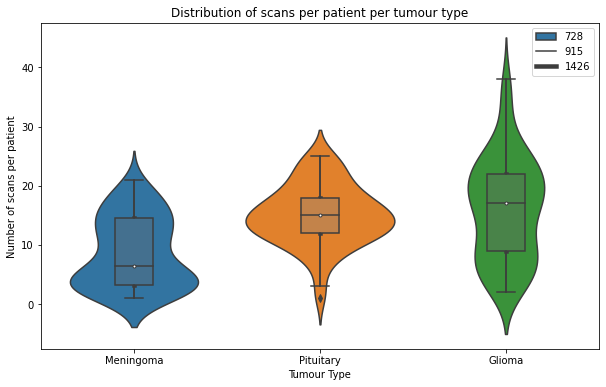

In [40]:
plt.figure(figsize=(10,6))
sns.violinplot(x=t_type, y=count_freq) 
sns.boxplot(x=t_type, y=count_freq, saturation=0.5, width=0.2, boxprops={'zorder': 2})
plt.xlabel('Tumour Type')
plt.ylabel("Number of scans per patient")
plt.title('Distribution of scans per patient per tumour type')
plt.legend(labels=['728', '915', '1426'])

So we can see that relatively speaking, the glioma tumour group has a higher occurence of patients with a larger number of images. 

This is clearly one of the contributing factors to the fact that the classes are imbalanced. 


But we'll account for these imbalances later on after our PCA. 


It is common practice to flatten image arrays so that we're dealing with 1-dimensional arrays rather than high multidimensional sets. 

We're going to use the flatten function to turn our 512 by 512 image array into a 1 by 262144

In [16]:
flat_images = []
for images in Total_images:
    flat_images.append(images.flatten()) # the variable flat_images now has all 3049 flat image arrays

Now that we have our flat images, we can move on to reducing the dimensions and eventually handling the imbalance of classes. 

We're going to install the necessary packages and tools for our PCA and under- or over-sampling.

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter

So the main update to the script is here, we are going to bin our features of the flat images into bin ranges of 50 points, from which the mean will be extracted to represent those points. We do this to reduce the computational load of our data, while still keeping the same number of samples. 

If this is still too much (the runtime) with binning 50 points together, you can increase the width of the bin to even further reduce the size. This will obviously most likely have some negative effect on the performance of the classification models.


Then, we're going to scale our binned flat image arrays before using PCA using the StandardScaler function.

The type of scaling we're doing here is just minusing the mean and dividing by the standard deviation.

In [213]:
width = 50 # the width is size of our bin
binned_flatimages = [] # list to enter our new binned values
for i in range(len(flat_images)):
    FI_i = flat_images[i]
    binned_FI = FI_i[:(bfi_1.size // width) * width].reshape(-1, width).mean(axis=1) # we just use some functions within numpys package 
    binned_flatimages.append(binned_FI)

In [215]:
len(binned_flatimages[0])

5242

So we've reduced the scale of our data from 262400 features down to 5242

Now we can scale these points

In [228]:
df = pd.DataFrame(binned_flatimages) 
scale = StandardScaler() # standard scaling
dat_scal = scale.fit_transform(df) 
df = pd.DataFrame(dat_scal)
df['tumour type']=t_scorelist
x = df.iloc[:,:-1] # We'll then split the data to just input the predictor variables into our PCA
y = df.iloc[:,-1] 

When looking at our x variable, it contains all the values we want to input into the PCA,

it should be a table of 3049 x 5242 numeric values 

In [229]:
x

,0,1,2,3,4,5,6,7,8,9,...,5232,5233,5234,5235,5236,5237,5238,5239,5240,5241
0,-0.178518,-0.504056,-0.454077,-0.397536,-0.343228,-0.348759,-0.302993,-0.274817,-0.235318,-0.667318,...,-0.233425,-0.167992,-0.302030,-0.422985,-0.627643,-0.685703,-0.676079,-0.637507,-0.488719,-0.448175
1,-0.178518,-0.504056,-0.454077,-0.397536,-0.343228,-0.348759,-0.302993,-0.274817,-0.235318,-0.667318,...,-0.233425,-0.167992,-0.302030,-0.422985,-0.627643,-0.685703,-0.676079,-0.637507,-0.488719,-0.448175
2,-0.178518,-0.504056,-0.454077,-0.397536,-0.343228,-0.348759,-0.302993,-0.274817,-0.235318,-0.667318,...,-0.233425,-0.167992,-0.302030,-0.422985,-0.627643,-0.685703,-0.676079,-0.637507,-0.488719,-0.448175
3,-0.178518,-0.504056,-0.454077,-0.397536,-0.343228,-0.348759,-0.302993,-0.274817,-0.235318,-0.667318,...,-0.233425,-0.167992,-0.302030,-0.422985,-0.627643,-0.685703,-0.676079,-0.637507,-0.488719,-0.448175
4,-0.178518,-0.504056,-0.454077,-0.397536,-0.343228,-0.348759,-0.302993,-0.274817,-0.235318,-0.667318,...,-0.233425,-0.167992,-0.302030,-0.422985,-0.627643,-0.685703,-0.676079,-0.637507,-0.488719,-0.448175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,-0.178518,-0.504056,-0.338097,-0.101411,-0.090476,-0.078502,-0.044937,0.087307,0.142418,4.054112,...,1.610015,-0.167992,-0.293554,-0.295798,-0.387996,0.495286,1.403762,2.240948,0.555626,1.185807
3045,-0.178518,-0.504056,-0.324566,-0.096246,-0.079962,-0.063894,-0.028934,0.077418,0.149753,3.111118,...,1.691203,-0.167992,-0.276604,-0.298090,-0.042639,0.967158,0.862253,0.701873,0.691008,1.372387
3046,-0.178518,-0.504056,-0.243380,-0.035988,-0.058094,-0.066815,0.005074,0.109439,0.165156,2.277924,...,1.457191,-0.167992,-0.270550,-0.128125,0.479572,1.198682,1.122632,1.385415,0.701585,1.636531
3047,-0.178518,-0.504056,-0.454077,-0.397536,-0.343228,-0.348759,-0.302993,-0.274817,-0.235318,-0.667318,...,-0.233425,-0.167992,-0.302030,-0.422985,-0.627643,-0.685703,-0.676079,-0.637507,-0.488719,-0.448175


In [230]:
y

0       1
1       1
2       1
3       1
4       1
       ..
3044    2
3045    2
3046    2
3047    1
3048    1
Name: tumour type, Length: 3049, dtype: int64

So first thing we can see from our data is that we have a lot of variables for our samples when we flatten out the images, even after binning them. 
But when we look at the first 2 columns from the normalised dataset, we see that they are filled with the same values, at least for a lot of their entries. 
These are the black spaces of the MRI images and obviously do not give us a lot of information. Unfortunately almost all of the images have a lot of these data entries, just uninformative black 'pixels'. 

So obviously to account for this, we should try some dimensionality reduction techniques. 
We also have class imbalances within our prediction outcomes or tumour types. We can deal with this by implementing some over and under sampling methods to our training set for the models. 



For this review script, we're going to look at using just PCA and SMOTE oversampling.

So given that we simply have a lot of variables, in addition, we have a lot of black (nothing) in our images, so therefore it's probably a good idea to try some principal component analysis. 

# Priniciple Component Analysis 

We want to account for 95% of the variation from the original dataset

In [321]:
pca = PCA(0.95)
pcacomp = pca.fit_transform(x) # hopefully the PCA doesn't take too long now
pcacomp.shape# Check the shape of the pca set to see how many components we retrieve for 95% variance explained


2022-10-21 18:15:26.738203
2022-10-21 18:15:39.242327


(3049, 118)

In [322]:
pcacomp1 = np.column_stack((pcacomp, y))
len(pcacomp1[0])

119

As you can see, the PCA assigned 118 principle components to explain 95% of the variance. 
If you remember from our previous PCA with the full scaled dataset, it assigned over 700 components for the same variance explained. So therefore the binning of the features of the flat images really did help with reducing the magnitude of the data. 

We can plot the individual explained variance per component as well as the cumulative explained variance for a consecutively increasing number of componets. 

In [325]:
exp_var_pca = pca.explained_variance_ratio_ # obtaining every components explained variance
cum_sum_var = np.cumsum(exp_var_pca) # obtaining the cumulative sum of the explained variance
# these are then plotted blow

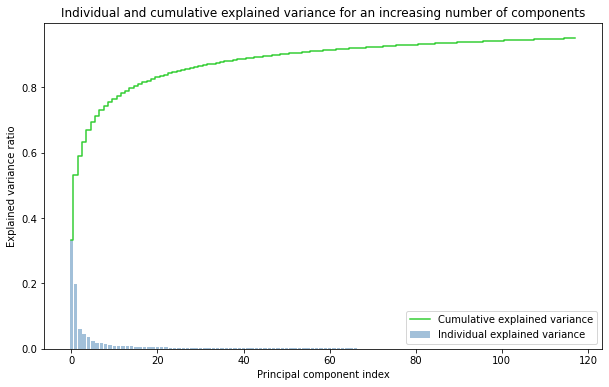

In [326]:
plt.figure(figsize=(10,6))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance', color = 'steelblue')
plt.step(range(0,len(cum_sum_var)), cum_sum_var, where='mid',label='Cumulative explained variance', color = 'limegreen')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='lower right')
plt.rc('axes', labelsize=10) 
plt.title('Individual and cumulative explained variance for an increasing number of components')
plt.show()



It's pretty clear that we shouldn't be using the entire number of components (n=746), the cumulative explained variance flattens out a bit after 60 components or so. 

So let's just plot the same plot for the first 50 components. 

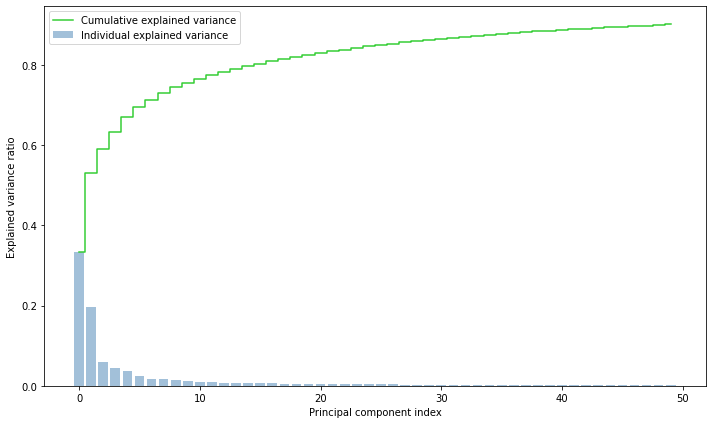

In [327]:
exp_var_pca100 = pca.explained_variance_ratio_[:50]
H_sum_eigenvalues = np.cumsum(exp_var_pca100)
plt.figure(figsize=(10,6))
plt.bar(range(0,len(exp_var_pca100)), exp_var_pca100, alpha=0.5, align='center', label='Individual explained variance', color = 'steelblue')
plt.step(range(0,len(H_sum_eigenvalues)), H_sum_eigenvalues, where='mid',label='Cumulative explained variance', color = 'limegreen')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Let's say we're happy with just 90% of the variance embedded within our data.

Let's retreive only these first 50 components out of 118.

Thus overall giving us a new dataset of 3049 samples and 50 features.

In [262]:
pca_x = pcacomp[:,:50]
pcacomp1 = np.column_stack((pca_x, y))
print(pcacomp1[0]) # these are now the values represented in one sample
# we'll just plot the first sample as an example

[ 13.22405456 -28.4200137   11.51288723  -0.49736148  -7.16346394
  -0.48416522  -3.89390246   6.88785414   3.37820895  -0.02978108
  -8.03642378  -8.63980601   1.04259219   1.66974394   1.46409382
   4.0257148   -6.00550578   4.88122205  -0.17180381   0.79949581
   0.87967833   3.68489606  -7.64953478   8.77047316   6.25309132
  -2.76878896  -0.88580895   1.56366634   8.26073927  -1.10969693
   1.93712832  -1.71413816   3.29238357   2.34429222  -3.28850683
   3.71042215   0.76875546   3.81238004   3.18674118  -3.14191151
  -0.91133896  -2.07948928   1.19365436   1.28726202  -0.59725674
  -0.97014239   3.34044868  -2.3843788    1.87360547  -1.18103497
   1.        ]


In [263]:
print(f"The total explained variance from the selected component features is {sum(pca.explained_variance_ratio_[:50])}")

The total explained variance from the selected component features is 0.9010480932824434


Let's join the new reduced data, and for the sake of visualising the classes within the 2 principle components plot, we're going to be assigning what class they are.

In [268]:
pca1 = pcacomp1[:,50]==1 # meningioma 
pca2 = pcacomp1[:,50]==2 # Glioma 
pca3 = pcacomp1[:,50]==3 # Pituitary 

Now we can plot the principal components, or at least the first three against each other to observe if the variance can separate our groups at all. 

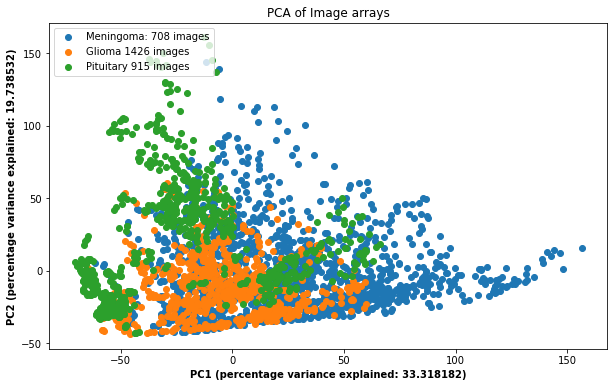

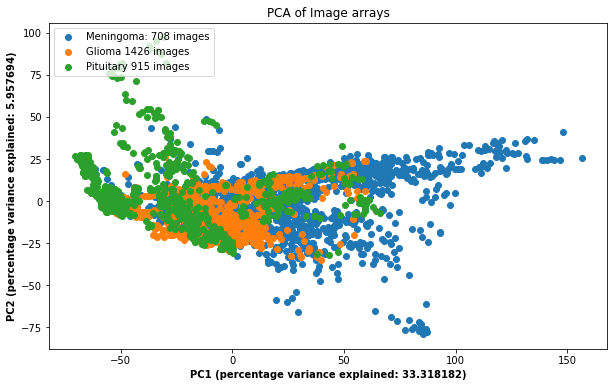

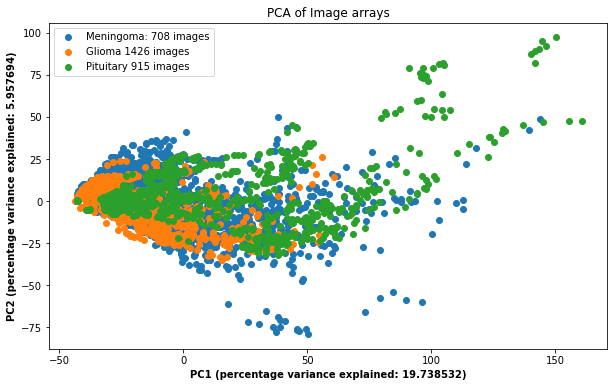

In [270]:
# First two components 
plt.figure(figsize=(10,6))
plt.title('PCA of Image arrays')
plt.scatter(pcacomp1[pca2,0], pcacomp1[pca2,1], label = f'Meningoma: {len(pcacomp1[pca1,])} images')
plt.scatter(pcacomp1[pca1,0], pcacomp1[pca1,1], label = f'Glioma {len(pcacomp1[pca2,])} images')
plt.scatter(pcacomp1[pca3,0], pcacomp1[pca3,1], label = f'Pituitary {len(pcacomp1[pca3,])} images')
plt.xlabel('PC1 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[0]*100) ,fontweight='bold')
plt.ylabel('PC2 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[1]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()

# First and third components 
plt.figure(figsize=(10,6))
plt.title('PCA of Image arrays')
plt.scatter(pcacomp1[pca2,0], pcacomp1[pca2,2], label = f'Meningoma: {len(pcacomp1[pca1,])} images')
plt.scatter(pcacomp1[pca1,0], pcacomp1[pca1,2], label = f'Glioma {len(pcacomp1[pca2,])} images')
plt.scatter(pcacomp1[pca3,0], pcacomp1[pca3,2], label = f'Pituitary {len(pcacomp1[pca3,])} images')
plt.xlabel('PC1 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[0]*100) ,fontweight='bold')
plt.ylabel('PC2 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[2]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()

# Second and third components 
plt.figure(figsize=(10,6))
plt.title('PCA of Image arrays')
plt.scatter(pcacomp1[pca2,1], pcacomp1[pca2,2], label = f'Meningoma: {len(pcacomp1[pca1,])} images')
plt.scatter(pcacomp1[pca1,1], pcacomp1[pca1,2], label = f'Glioma {len(pcacomp1[pca2,])} images')
plt.scatter(pcacomp1[pca3,1], pcacomp1[pca3,2], label = f'Pituitary {len(pcacomp1[pca3,])} images')
plt.xlabel('PC1 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[1]*100) ,fontweight='bold')
plt.ylabel('PC2 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[2]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()


At first glance, the different classes are unfortunately not so well separated, but this is not so suprising. 
Despite this, the explained variance in PC1 is relatively high with 33% and the 2nd PC with 20%. 

In essence we can assume that using the top 50 priniciple components will be more efficient than using each patient's entire flattened image array. 

In [271]:
pca_train = pcacomp1[:,:50]
pca_y = pcacomp1[:,50]
print(pca_train.shape)
print(pca_y)
print(pca_y.shape)

(3049, 50)
[1. 1. 1. ... 2. 1. 1.]
(3049,)


Now that we have our dimensionally reduced dataset with our 50 PCs, we can split it into training and testing sets, from which the training set wil be upsampled to get rid of the class imbalances. 

Remeber that we need to split the data into the testing and training sets as we do not want data leaks in our models. Using non-random sampling methods such as SMOTE already account for this a bit by retrieving technically 'new' samples that are derived from a knn-based algorithms of similarity measures.

In [272]:
from sklearn.model_selection import train_test_split # test_size: what proportion of original data is used for test set
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve


We are going to use the train_test_split function from sklearn that easily allows us to stratify the splits based on the class occurences.

In [273]:
x_train,x_test,y_train,y_test=train_test_split(pca_train,pca_y,test_size=0.20, # using a 80:20 training:testing split
                                               random_state=77, # Keep the seed
                                               stratify=pca_y) # stratifying it based on the classes

# We can see the sizes of the sample separations before we upsample the training set 
print(len(x_train),len(x_test),len(y_train),len(y_test))


2439 610 2439 610


# OVERSAMPLING

We're first going to try SMOTE oversampling 
Quick reminder: 
Oversampling is a method for resampling the minority class proprtion (pituitary and meningioma class tumours) after the majority class proportion (glioma). 
SMOTE stands for Synthetic Minority Oversampling Technique, it works differently than your typical oversampling methods. 

In classic oversampling techniques, the minority data is duplicated from the minority data population. While it does increase the number of data points, it does not give any new information or variation to our machine learning model.

SMOTE is different by creating synthetic data. It works by utilizing a k-nearest neighbour algorithm to create the new synthetic points. It will choose a random data from the minority class, then k-nearest neighbours from the data are set, and the synthetic data will then be made to be between these points. Repeating this process until the number of points equal the majority class. 

In [274]:
x_resampled_SMOTE, y_resampled_SMOTE = SMOTE().fit_resample(x_train, y_train)
print(type(y_train))
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_resampled_SMOTE).items()))

<class 'numpy.ndarray'>
[(1.0, 566), (2.0, 1141), (3.0, 732)]
[(1.0, 1141), (2.0, 1141), (3.0, 1141)]


We can see that now patient samples with the tumour types = 1 and 3 (meningioma and pituitary), they have an increased number of samples to match those of the glioma group (type = 2)

In [275]:
pcacomp1_S = np.column_stack((x_resampled_SMOTE, y_resampled_SMOTE))

In [276]:
print(x_resampled_SMOTE.shape)
y_resampled_SMOTE

(3423, 50)


array([2., 1., 2., ..., 3., 3., 3.])

We now have 3423 samples in our training set, with nicely balanced classes. 

Just out of interest, we can visualise the newly created samples within the same space we were looking previously at our original samples, within our first few components. 

In [278]:
pca1s = pcacomp1_S[:,50]==1
pca2s = pcacomp1_S[:,50]==2
pca3s = pcacomp1_S[:,50]==3


We repeat the plots again, but comparing them to the same plots with more data points upsampled from the PCs 

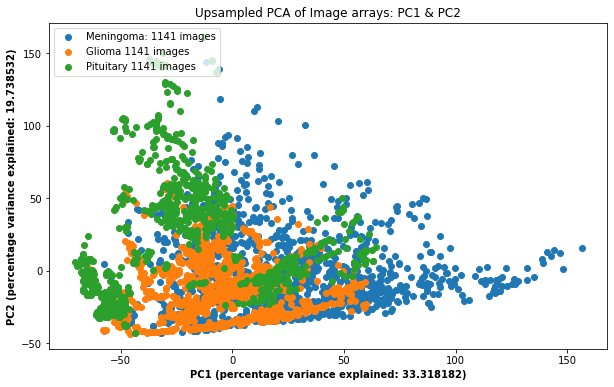

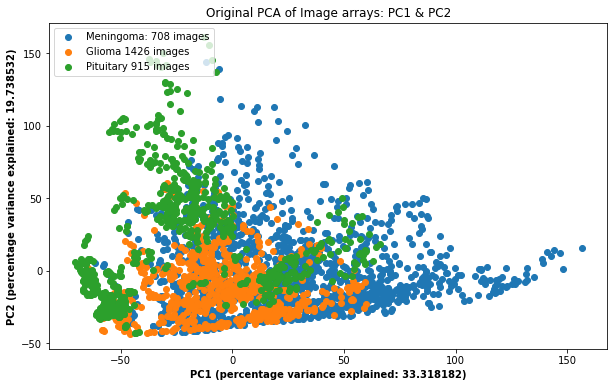

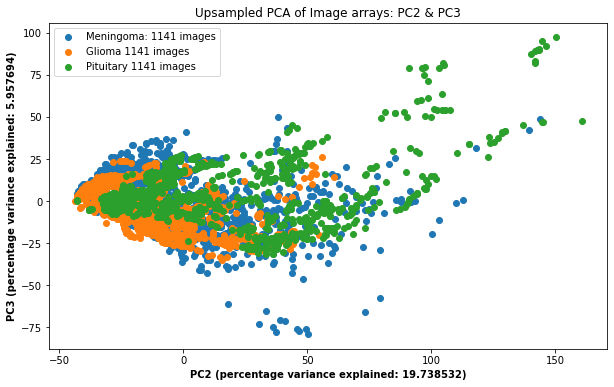

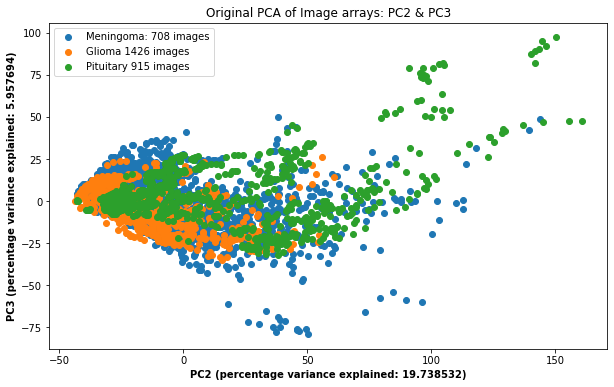

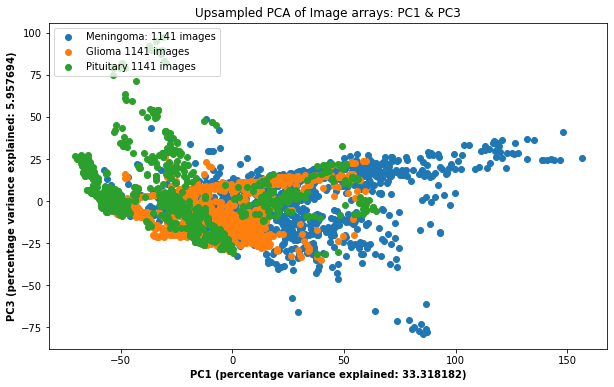

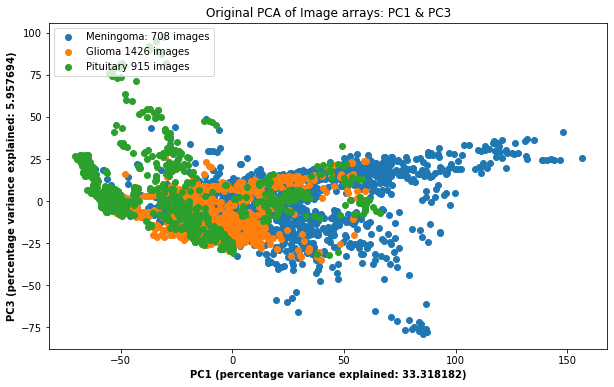

In [282]:
plt.figure(figsize=(10,6))
plt.title('Upsampled PCA of Image arrays: PC1 & PC2')
plt.scatter(pcacomp1_S[pca2s,0], pcacomp1_S[pca2s,1], label = f'Meningoma: {len(pcacomp1_S[pca1s,])} images')
plt.scatter(pcacomp1_S[pca1s,0], pcacomp1_S[pca1s,1], label = f'Glioma {len(pcacomp1_S[pca2s,])} images')
plt.scatter(pcacomp1_S[pca3s,0], pcacomp1_S[pca3s,1], label = f'Pituitary {len(pcacomp1_S[pca3s,])} images')
plt.xlabel('PC1 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[0]*100) ,fontweight='bold')
plt.ylabel('PC2 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[1]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.title('Original PCA of Image arrays: PC1 & PC2')
plt.scatter(pcacomp1[pca2,0], pcacomp1[pca2,1], label = f'Meningoma: {len(pcacomp1[pca1,])} images')
plt.scatter(pcacomp1[pca1,0], pcacomp1[pca1,1], label = f'Glioma {len(pcacomp1[pca2,])} images')
plt.scatter(pcacomp1[pca3,0], pcacomp1[pca3,1], label = f'Pituitary {len(pcacomp1[pca3,])} images')
plt.xlabel('PC1 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[0]*100) ,fontweight='bold')
plt.ylabel('PC2 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[1]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.title('Upsampled PCA of Image arrays: PC2 & PC3')
plt.scatter(pcacomp1_S[pca2s,1], pcacomp1_S[pca2s,2], label = f'Meningoma: {len(pcacomp1_S[pca1s,])} images')
plt.scatter(pcacomp1_S[pca1s,1], pcacomp1_S[pca1s,2], label = f'Glioma {len(pcacomp1_S[pca2s,])} images')
plt.scatter(pcacomp1_S[pca3s,1], pcacomp1_S[pca3s,2], label = f'Pituitary {len(pcacomp1_S[pca3s,])} images')
plt.xlabel('PC2 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[1]*100) ,fontweight='bold')
plt.ylabel('PC3 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[2]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.title('Original PCA of Image arrays: PC2 & PC3')
plt.scatter(pcacomp1[pca2,1], pcacomp1[pca2,2], label = f'Meningoma: {len(pcacomp1[pca1,])} images')
plt.scatter(pcacomp1[pca1,1], pcacomp1[pca1,2], label = f'Glioma {len(pcacomp1[pca2,])} images')
plt.scatter(pcacomp1[pca3,1], pcacomp1[pca3,2], label = f'Pituitary {len(pcacomp1[pca3,])} images')
plt.xlabel('PC2 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[1]*100) ,fontweight='bold')
plt.ylabel('PC3 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[2]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.title('Upsampled PCA of Image arrays: PC1 & PC3')
plt.scatter(pcacomp1_S[pca2s,0], pcacomp1_S[pca2s,2], label = f'Meningoma: {len(pcacomp1_S[pca1s,])} images')
plt.scatter(pcacomp1_S[pca1s,0], pcacomp1_S[pca1s,2], label = f'Glioma {len(pcacomp1_S[pca2s,])} images')
plt.scatter(pcacomp1_S[pca3s,0], pcacomp1_S[pca3s,2], label = f'Pituitary {len(pcacomp1_S[pca3s,])} images')
plt.xlabel('PC1 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[0]*100) ,fontweight='bold')
plt.ylabel('PC3 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[2]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.title('Original PCA of Image arrays: PC1 & PC3')
plt.scatter(pcacomp1[pca2,0], pcacomp1[pca2,2], label = f'Meningoma: {len(pcacomp1[pca1,])} images')
plt.scatter(pcacomp1[pca1,0], pcacomp1[pca1,2], label = f'Glioma {len(pcacomp1[pca2,])} images')
plt.scatter(pcacomp1[pca3,0], pcacomp1[pca3,2], label = f'Pituitary {len(pcacomp1[pca3,])} images')
plt.xlabel('PC1 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[0]*100) ,fontweight='bold')
plt.ylabel('PC3 (percentage variance explained: %f)' %(pca.explained_variance_ratio_[2]*100) ,fontweight='bold')
plt.legend(loc='upper left')
plt.show()


By looking at the plots above, we can do a quick informal check and make sure that our newly generated samples are still withinn a reasonable space of variance explained as our original samples. As we can see, the above plots look very similar and therefore we can assume our new samples are not distorting the information from our original sample. 



Hopefully this is dimensionally reduced dataset with more balanced classes will help us develop stronger models. 

Now we can actually move onto developing some classification models. 
For the sake of this review, we'll just work on developing the following models: 
- an optimized K-Nearest Neighbours model. 
- as well, a support vector machine with a linear kernel

# KNN on our SMOTE upsampled dataset

In [283]:
knn = KNeighborsClassifier(n_neighbors=5) # setting our k (# of neighbours) to 5 

In [285]:
knn.fit(x_resampled_SMOTE,y_resampled_SMOTE)
print('KNN Model is trained with the upsampled dataset')

KNN Model is trained with the upsampled dataset


In [286]:
knn_y_pred=knn.predict(x_test)
acc = round(sum(knn_y_pred==y_test)/len(y_test),2)
print(f"The model is {acc*100}% accurate")

The model is 92.0% accurate


We can observe the confusion matrix to better see how the false positives and negatives were distributed among the classes. 

As well, we'll use the matthew's correlation coefficient to measure our model's performance. 
A value of 1 indicates a perfect model, while a value of 0 indicates the model is the same as randomly guessing the outcome. 


In [287]:
print("Resulting confusion matrix from knn model")
print(confusion_matrix(y_test, knn_y_pred)) 
print(f" The MCC is {matthews_corrcoef(y_test, knn_y_pred)}")

Resulting confusion matrix from knn model
[[127  12   3]
 [ 25 256   4]
 [  3   1 179]]
 The MCC is 0.8785130635946132


We can also do a manual iteration through various k values (1 to 30), and then check how these affect the model's performances. 

In [312]:
k_scores = []
ith = []
mccs = []
error_rate = []
pr = []
rc = []
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_resampled_SMOTE,y_resampled_SMOTE)
    print('The Model is trained well with the given images')
    knn_y_pred=knn.predict(x_test)
    acc = round(sum(knn_y_pred==y_test)/len(y_test),2)
    #print(f"The model is {acc*100}% accurate with k set to {i}")
    #print(confusion_matrix(y_test, knn_y_pred))
    #print(matthews_corrcoef(y_test, knn_y_pred))
    mcc_k = matthews_corrcoef(y_test, knn_y_pred)
    mccs.append(mcc_k)
    ith.append(k)
    er_k = error_rate.append(np.mean(knn_y_pred != y_test))
    pr_k = precision_score(y_test, knn_y_pred, average='macro')
    rc_k = recall_score(y_test, knn_y_pred, average='macro')
    pr.append(pr_k)
    rc.append(rc_k)
    print(f"The mcc with k = {k} is {mcc_k}")


The Model is trained well with the given images
The mcc with k = 1 is 0.9460626213856289
The Model is trained well with the given images
The mcc with k = 2 is 0.9061410570364218
The Model is trained well with the given images
The mcc with k = 3 is 0.9007924430721238
The Model is trained well with the given images
The mcc with k = 4 is 0.8794300997217546
The Model is trained well with the given images
The mcc with k = 5 is 0.8785130635946132
The Model is trained well with the given images
The mcc with k = 6 is 0.847667010832464
The Model is trained well with the given images
The mcc with k = 7 is 0.8445988869968414
The Model is trained well with the given images
The mcc with k = 8 is 0.8208876396288305
The Model is trained well with the given images
The mcc with k = 9 is 0.822866678587459
The Model is trained well with the given images
The mcc with k = 10 is 0.8002323388079793
The Model is trained well with the given images
The mcc with k = 11 is 0.7904020380091926
The Model is trained 

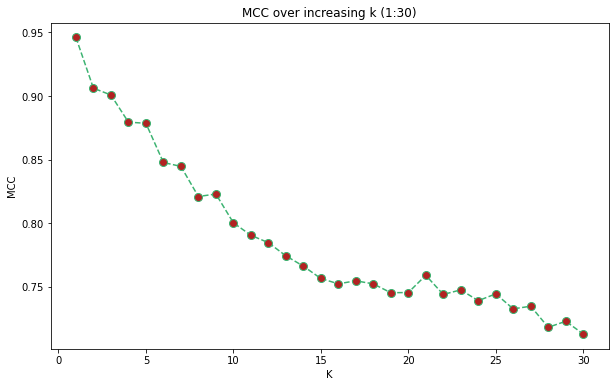

Highest MCC = 0.8794300997217546 at K = 4
Minimum error = 0.07868852459016394 at K = 5


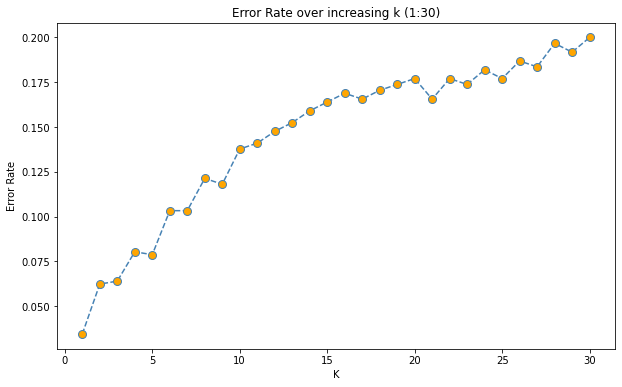

In [313]:
plt.figure(figsize=(10,6))
plt.plot(ith, mccs, color='mediumseagreen', linestyle='dashed', marker='o',markerfacecolor='firebrick', markersize=8)
plt.title('MCC over increasing k (1:30)')
plt.xlabel('K')
plt.ylabel('MCC')
plt.show()
print("Highest MCC =",max(mccs[3:]),"at K =",mccs.index(max(mccs[3:]))+1)

plt.figure(figsize=(10,6))
plt.plot(ith,error_rate,color='steelblue', linestyle='dashed', 
         marker='o',markerfacecolor='orange', markersize=8)
plt.title('Error Rate over increasing k (1:30)')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error =",min(error_rate[3:]),"at K =",error_rate.index(min(error_rate[3:]))+1)



I've chosen 5 as the optimal k value, because having it too small will cause overfitting with our model, while too large values will over generalize our models. In my opinion, it's worth slightly decreasing the accuracy in order to have one more neighbour incorporated for each prediction. 

#  SVM on our SMOLE upsampled dataset

In [328]:
svc = svm.SVC(kernel = 'linear', C = 10)

So with support vector machines, they are inherently comprised for binary claassificaiton problems. Luckily with packages such as sklearn, we can just implement a simple One-vs-the-rest approach. So in essence the algorithm will just treat the other two tumour classes in the moment as 'the other' data and calssify the class at hand against both of them, rather than treating it as a multiclass problem. 

In [329]:
svc = OneVsRestClassifier(svc, n_jobs = -2) 

setting n_jobs to -2, allows us to implement some parallel programprocessing into the model development. 

By setting it to -2, we say that we want to use all CPU cores (depends on computer) except for one. 
You can shange this value to 1, 2, etc... Setting it to -1 will use all cores available. 

Hopefully making a significant impact in the comutational time. 

In [334]:
svc.fit(x_resampled_SMOTE, y_resampled_SMOTE)

OneVsRestClassifier(estimator=SVC(C=10, kernel='linear'), n_jobs=-2)

We'll now predict our original test sample from the imbalanced data. 

In [335]:
svm_y_pred = svc.predict(x_test)

In [336]:
acc = round(sum(svm_y_pred==y_test)/len(y_test),2) # calculating the general accuracy 
print(f"The model has a general accuracy of {acc*100}%")

The model has a general accuracy of 78.0%


In [337]:
print(confusion_matrix(y_test, svm_y_pred))
 
matthews_corrcoef(y_test, svm_y_pred)

[[ 96  35  11]
 [ 70 210   5]
 [ 13   1 169]]


0.6647721482644026

The next cells contain a model using SVMs linear kernel with some optimization for C. 

# CAUTION!! 
Do not run unless you have either a pretty decent processing power on your computer or a lot of time. 
So for the sake of the review, I would not run this. 

I do not expect you to run this, I only wanted to show how we can implement some parameter optimization. 
It's a similar way to do it for non-linear kernels such as rbf or polynomial, we just have more parameters. 

In [ ]:
param_grid = {'C':[0.1, 1, 10]}
svc_gs = svm.SVC(kernel = 'linear')
svc_gs = GridSearchCV(svc_gs,param_grid)
svc_gs = OneVsRestClassifier(svc_gs, n_jobs = -2)

In [ ]:
svc_gs.fit(x_resampled_SMOTE, y_resampled_SMOTE)
svm_gs_pred=svc_gs.predict(x_test)
acc = round(sum(svm_gs_pred==y_test)/len(y_test),2) # calculating the general accuracy 
print(f"The model is {acc*100}% accurate")
print(confusion_matrix(y_test, svm_gs_pred))
matthews_corrcoef(y_test, svm_gs_pred)